In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from functions import *

# 1 Folder Data loading
The code is loading multiple CSV files from a specified folder path and converting them into pandas DataFrames.

In [408]:
folder_path = "data/e production=ep sanyo ep sanyo 031"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

dataframes = []
dfarrnames = []

# Loop through the CSV files and load only those ending with "Format01=Kreis 5-064" and "TBA_CU"
for csv_file in csv_files:
    if "Format01=Kreis" in csv_file:
        if "TBA_CU" in csv_file:
            dfarr = pd.read_csv(csv_file, skiprows=[1])
            dfarr['Zeit'] = dfarr['Zeit'].apply(convert_to_linear_time)
            dfarr['Zeit'] = dfarr['Zeit'] - dfarr['Zeit'].iloc[0]
            dfarr['Zeit'] = dfarr['Zeit'] / 3600
            dataframes.append(dfarr)
            dfarrnames.append(csv_file)

noFiles = 0
for i, dfarr in enumerate(dataframes):
    num_rows, num_columns = dfarr.shape
    print(f"DataFrame {i + 1} - Rows: {num_rows}, Columns: {num_columns}")
    noFiles += 1
print(noFiles)

DataFrame 1 - Rows: 25239, Columns: 18
DataFrame 2 - Rows: 25069, Columns: 18
DataFrame 3 - Rows: 24863, Columns: 18
DataFrame 4 - Rows: 25150, Columns: 18
DataFrame 5 - Rows: 24789, Columns: 18
DataFrame 6 - Rows: 24909, Columns: 18
DataFrame 7 - Rows: 24970, Columns: 18
DataFrame 8 - Rows: 26194, Columns: 18
DataFrame 9 - Rows: 27085, Columns: 18
DataFrame 10 - Rows: 28685, Columns: 18
DataFrame 11 - Rows: 30608, Columns: 18
DataFrame 12 - Rows: 28372, Columns: 18
DataFrame 13 - Rows: 39225, Columns: 18
DataFrame 14 - Rows: 40697, Columns: 18
DataFrame 15 - Rows: 41889, Columns: 18
DataFrame 16 - Rows: 42082, Columns: 18
16


test that data is loaded succesfully

In [ ]:
num_rows, num_columns = dataframes[1].shape

print(f"Number of rows (length): {num_rows}")
print(f"Number of columns (width): {num_columns}")
dataframes[i].head()

### Crop The Values

In [409]:
filtered_dataframes = []

for df in dataframes:
    schritt_mask = ((df['Schritt'] == 4) | (df['Schritt'] == 5)) & (df['Zeit'] >= 10)
    start_index = df[schritt_mask]
    start_time = start_index.iloc[0]['Zeit']
    end_time = start_time + 4
    print(start_index.iloc[0]['Zeit'])

    time_mask = (df['Zeit'] >= start_time) & (df['Zeit'] <= end_time) & ((df['Schritt'] == 4) | (df['Schritt'] == 5))

    filtered_df = df[time_mask]
    filtered_dataframes.append(filtered_df)

16.77068888889419
16.4906055555741
16.408974999984107
16.164416666693157
16.67292222228315
16.421491666701105
16.604397222267256
17.42458611110846
17.849049999978806
18.53656666662958
18.603955555558205
18.930958333346577
18.086350000037086
17.677380555537013
17.389549999965563
16.772213888896836


### Plot all data from folder
The code snippet is defining a list `columns_to_plot` which contains the column numbers (indices) of the columns to be plotted. It then iterates over a list of dataframes (`dataframes`) and for each dataframe, it prints the graph number, calls a function `plot_threshold` passing the `columns_to_plot`, the current dataframe, and two threshold values start and end time as arguments. The variable `I` is used as a counter to keep track of the graph number.

In [ ]:
columns_to_plot = [15,9] 
I = 0
for i in dataframes:
    print("Graph No. :",I)
    print(dfarrnames[I])
    start_time = filtered_dataframes[I].iloc[0]['Zeit']
    plot_threshold(columns_to_plot, filtered_dataframes[I],start_time,start_time+3.5)
    I=I+1

# 2 Capacity Analysis
### Max Min Value extration
this code is extracting the `maximun` and `minimum` value between the start and end time for all files in folder.It also captures the capacity using `capacity = max - min` and store the data in the array.  

In [410]:
columns_to_plot = [9]

max_values_list = []
min_values_list = []
capacity_values_list = []
iteration_range = range(len(dataframes))

for df in filtered_dataframes:
    max_values = max_threshold(columns_to_plot, df, 0, 35)
    min_values = min_threshold(columns_to_plot, df, 0, 35)
    
    max_values_list .append(max_values)
    min_values_list.append(min_values)
    capacity = max_values[0]-min_values[0]
    capacity_values_list.append(capacity)

print(max_values_list)
print(min_values_list)
print(capacity_values_list)
print(iteration_range)

[[2.477349919565313], [2.472444198330777], [2.465188956608472], [2.461330952937715], [2.454018688895303], [4.099979164311662], [2.455281442504202], [2.453320580305444], [2.455478051408136], [2.452184596804727], [2.379392804254167], [2.371394099918689], [2.320151298616111], [2.27876275026938], [2.249833732461411], [2.225982277239382]]
[[0.7039057398960722], [0.7360284666128791], [0.7668069726869362], [0.7991778948526189], [0.8249094756311024], [3.135964499088004], [0.90196688611195], [0.9735447575430952], [1.100000544916838], [1.274474787856889], [1.395740882762766], [1.54408579988376], [1.645413225360244], [1.716039775337777], [1.798439192765727], [1.832634974833127]]
[1.7734441796692408, 1.7364157317178979, 1.6983819839215357, 1.6621530580850963, 1.6291092132642007, 0.9640146652236585, 1.5533145563922521, 1.4797758227623485, 1.3554775064912978, 1.177709808947838, 0.983651921491401, 0.8273083000349288, 0.674738073255867, 0.562722974931603, 0.45139453969568377, 0.3933473024062548]
range

### Extract Requried data
`skip_indeces` are thoese which is creating problem in graph

In [413]:
skip_indices = [5]

extracted_capacity_values = [value for i, value in enumerate(capacity_values_list) if i not in skip_indices]

iteration_range = range(len(extracted_capacity_values))

print(extracted_capacity_values)
print(iteration_range)

[1.7734441796692408, 1.7364157317178979, 1.6983819839215357, 1.6621530580850963, 1.6291092132642007, 1.5533145563922521, 1.4797758227623485, 1.3554775064912978, 1.177709808947838, 0.983651921491401, 0.8273083000349288, 0.674738073255867, 0.562722974931603, 0.45139453969568377, 0.3933473024062548]
range(0, 15)


### ploting the capacity
It plot the capacity over days asuming that the each file in the folder is of one day.

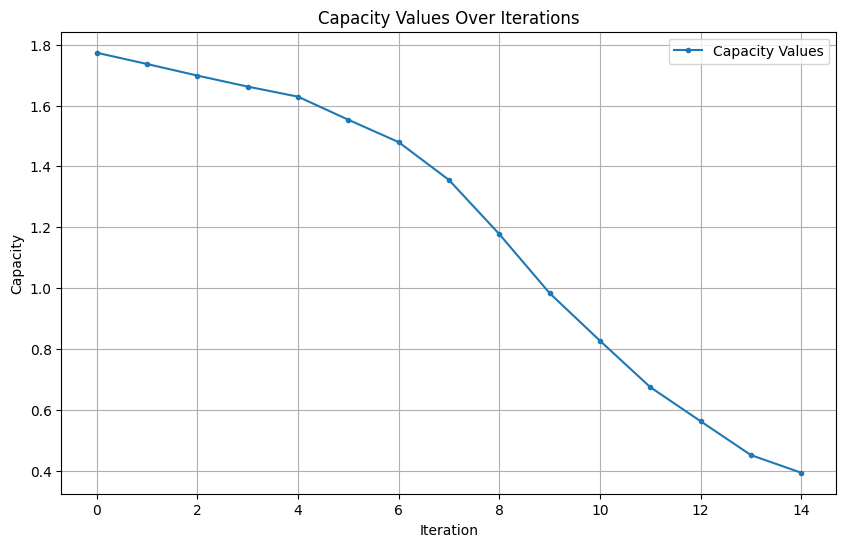

In [414]:
plt.figure(figsize=(10, 6))
plt.plot(iteration_range, extracted_capacity_values, label='Capacity Values', marker='.')
plt.xlabel('Iteration')
plt.ylabel('Capacity')
plt.legend()
plt.title('Capacity Values Over Iterations')
plt.grid(True)

plt.show()

### Save the graph data
this code is saving the data of the graphs for later use 
how to use
-  If you are using it first time  clear the data in `extracted_capacity_values.csv`
- first get your desired output on the above graph
- run this code only once
- it will store it in csv that you can later use to display all graphs at one

In [ ]:
csv_filename = "extracted_capacity_values_2.csv"

with open(csv_filename, 'a', newline='') as csvfile:
    values_as_string = ",".join(map(str, extracted_capacity_values))
    csvfile.write(values_as_string + "\n")

print(f"Values have been appended to the CSV file '{csv_filename}'")

### Ploting all Cell Data
This will take csv of the above code block and plot all the data that is stored aleady

In [ ]:
csv_file = 'extracted_capacity_values_2.csv'

csvdf = pd.read_csv(csv_file, header=None)

num_rows, num_columns = csvdf.shape

for row in range(num_rows):
    plt.plot(csvdf.iloc[row], label=f'Cell {row + 1}')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

plt.show()

# 3 Volatge Charging analysis

### Ploting Voltage
`data_extract` is the array of `(dataframe,starttime)`
- `starttime` is  the that you will place manully by using data above code output
- try to use first most value of the repected data frame if it is not working use the last one or randomly
- you can look above 35 graphs to figure out the proper value of  `starttime`
- `dataframe` is the correct that you want to include in the ploting 

Skipping index:  5


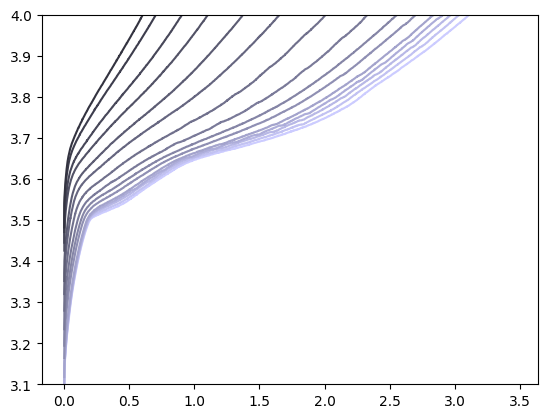

In [415]:
columns_to_plot = [15] 

plt1 = plt
i=0

for i,dataframe in enumerate(filtered_dataframes):
    if i not in skip_indices:
        start_time = filtered_dataframes[i].iloc[0]['Zeit']
        plot_threshold_same_plot(columns_to_plot, filtered_dataframes[i], start_time, start_time+4, plt1, y_min=3.1, y_max=4,i=i)
    else:
        print("Skipping index: ",i)
i=i+1

plt1.show()

### Croping Data

In [ ]:
import os
import csv

output_directory = "extracted_data"
os.makedirs(output_directory, exist_ok=True)

In [416]:
min_time = 3.1
max_time = 3.9
time_interval = 0.1

for current_time in np.arange(min_time, max_time + time_interval, time_interval):
    csv_filename = os.path.join(output_directory, f"extracted_voltage_data_{current_time:.1f}.csv")

    I = 0
    for index, dataframe in enumerate(filtered_dataframes):
        if index in skip_indices:
            print(f"Skipping index: {index}")
            continue

        voltage = []
        voltage = dataframe['Spannung']
        voltage_mask = (dataframe['Spannung'] >= current_time) & (dataframe['Spannung'] <= current_time + time_interval)
        voltage = voltage[voltage_mask]
        voltage = voltage.to_numpy()

        if not voltage.size:
            continue

        voltage_range = np.linspace(voltage.min(), voltage.max(), num=50)

        data =[]

        data = {'Spannung{}'.format(i + 1): value for i, value in enumerate(voltage_range)}
        data['Max_Capacity'] = max_values_list[I][0]
        data['Capacity'] = capacity_values_list[I]


        with open(csv_filename, 'a', newline='') as csv_file:
            writer = csv.DictWriter(csv_file, fieldnames=data.keys())
            #if index == 0:
            #    writer.writeheader()
            writer.writerow(data)

        I += 1

    print(f"Saved CSV file: {csv_filename}")

Skipping index: 5
Saved CSV file: extracted_data\extracted_voltage_data_3.1.csv
Skipping index: 5
Saved CSV file: extracted_data\extracted_voltage_data_3.2.csv
Skipping index: 5
Saved CSV file: extracted_data\extracted_voltage_data_3.3.csv


Skipping index: 5
Saved CSV file: extracted_data\extracted_voltage_data_3.4.csv
Skipping index: 5
Saved CSV file: extracted_data\extracted_voltage_data_3.5.csv
Skipping index: 5
Saved CSV file: extracted_data\extracted_voltage_data_3.6.csv
Skipping index: 5
Saved CSV file: extracted_data\extracted_voltage_data_3.7.csv
Skipping index: 5
Saved CSV file: extracted_data\extracted_voltage_data_3.8.csv
Skipping index: 5
Saved CSV file: extracted_data\extracted_voltage_data_3.9.csv
